# Fig. 5: Integrating data from single-cell and single-nucleus RNA sequencing

In this notebook, we inspect matched single-cell and single nucleus datasets generated from a single mouse brain tissue, and use a mechanistic model to explain the differences between the technologies.

In [1]:
import time
t1 = time.time()
import sys
sys.path.insert(0, 'src/')    # add monod to path
import monod
from monod import analysis
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import scipy

## Preliminaries: get fits, do goodness-of-fit testing

### seqFISH+ vs scRNA-seq

In [2]:
df = pd.read_csv('takei_khateb_comparison.csv',index_col=0)

x_column = 'Monod burst size'
y1_column = 'seqFISH+ burst size rep1'
y2_column = 'seqFISH+ burst size rep2'

log_seq_b = np.log10(df[x_column].values)
log_flo_b = 0.5*( np.log10(df[y1_column].values) + np.log10(df[y2_column].values) )

### snRNA-seq vs scRNA-seq

In [3]:
dataset_meta_sc = [f'brain_10x_30k_{i}' for i in range(1,5)]
dataset_meta_sn = [f'brain_nuc_10x_30k_{i}' for i in range(1,5)]
pair_ind = 3
dataset_names= [dataset_meta_sc[pair_ind],dataset_meta_sn[pair_ind]]
n_datasets = len(dataset_names)

dir_string = 'sn_vs_sc_package'
dataset_strings = [dir_string + '/' + x for x in dataset_names]
result_strings = [dir_string + '/'+x+'/Bursty_Poisson_20x21/grid_scan_results_upd.res' for x in dataset_names]

sd_arr = [monod.analysis.load_search_data(x+'/raw.sd') for x in dataset_strings]
sr_arr = [monod.analysis.load_search_results(x) for x in result_strings]
gf = (~sr_arr[1].rejected_genes)&(~sr_arr[0].rejected_genes)   # goodness-of-fit testing

In [4]:
# sanity check to make sure error bars are computed for correct parameter set
print(sr_arr[0].sigma_index)
print(sr_arr[0].samp_optimum_ind)

print(sr_arr[1].sigma_index)
print(sr_arr[1].samp_optimum_ind)

262
262
349
349


In [5]:
# parameters and uncertainties in log10 space
li = sr_arr[0].samp_optimum_ind
log_sc_b, log_sc_beta, log_sc_gamma = sr_arr[0].param_estimates[li].T

li = sr_arr[1].samp_optimum_ind
log_sn_b, log_sn_beta, log_sn_gamma = sr_arr[1].param_estimates[li].T

sig_sc_b, sig_sc_beta, sig_sc_gamma = sr_arr[0].sigma.T
sig_sn_b, sig_sn_beta, sig_sn_gamma = sr_arr[1].sigma.T

# find minimum uncertainty 
sig_min_b = np.minimum(sig_sc_b, sig_sn_b)
sig_min_beta = np.minimum(sig_sc_beta, sig_sn_beta)

# integrate estimates of b and beta
sig_int_b = np.sqrt( 1/( 1/sig_sc_b**2 + 1/sig_sn_b**2 ) )
sig_int_beta = np.sqrt( 1/( 1/sig_sc_beta**2 + 1/sig_sn_beta**2 ) )

print(sig_min_b.shape)

(2000,)


In [6]:
savedir = 'results/integration/'

-----------------

## 0. seqFISH+ and scRNA-seq burst size estimates are not very consistent

In [13]:
len(log_flo_b)

1964

R_b:  0.42411346294892716


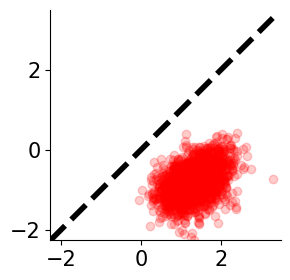

In [11]:
R_b, p_b = scipy.stats.pearsonr(log_seq_b, log_flo_b)
print("R_b: ", R_b)

alpha = 0.2
dpi = 450
b_color = 'red'

x_min, x_max = np.min((log_flo_b, log_seq_b)), np.max((log_flo_b, log_seq_b))
num_diag = 100; b_diag = np.linspace(x_min, x_max, num_diag)

# --------------------

fig, ax = plt.subplots(figsize=(3, 3))

ax.scatter(log_seq_b, log_flo_b, alpha=alpha, color=b_color)
ax.plot(b_diag, b_diag, linestyle='--', linewidth=4, color='black',zorder=3)

eps = 0.2
ax.set_xlim(x_min, x_max + eps); ax.set_ylim(x_min, x_max + eps)

ax.set_xticks([-2, 0, 2]); ax.set_yticks([-2, 0, 2])

ax.spines[['right', 'top']].set_visible(False)
ax.set_aspect('equal')
ax.tick_params(axis='both', labelsize=15)
fig.tight_layout()

formats = ['.png', '.svg', '.pdf']
for f in formats:
    plt.savefig(savedir+'flo_vs_seq_b_mismatch'+f, bbox_inches='tight', transparent=True, dpi=dpi)
plt.show()

## 1. Consistency of single-cell and single-nucleus estimates

In [15]:
len(log_sc_b[gf])

1896

R_b:  0.917875784358617
R_beta:  0.9716839230179559


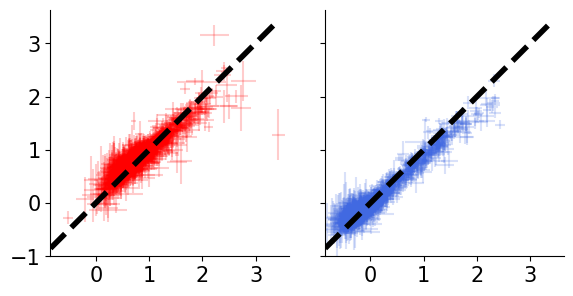

In [10]:
R_b, p_b = scipy.stats.pearsonr(log_sc_b[gf], log_sn_b[gf])
R_beta, p_beta = scipy.stats.pearsonr(log_sc_beta[gf], log_sn_beta[gf])
print("R_b: ", R_b)
print("R_beta: ", R_beta)

c=2.576

ncols = 2
alpha = 0.2
b_color = 'red'
beta_color = 'royalblue'
dpi = 450

b_min, beta_min = np.min((log_sc_b[gf], log_sn_b[gf])), np.min((log_sc_beta[gf], log_sn_beta[gf]))
b_max, beta_max = np.max((log_sc_b[gf], log_sn_b[gf])), np.max((log_sc_beta[gf], log_sn_beta[gf]))
x_min = np.min((b_min, beta_min))
x_max = np.max((b_max, beta_max))

num_diag = 100
b_diag = np.linspace(x_min, x_max, num_diag); beta_diag = np.linspace(x_min, x_max, num_diag)

# --------------------

fig, ax = plt.subplots(ncols = ncols, figsize=(6., 3), sharey=True, sharex=True)

#ax[0].scatter(log_sc_b[gf], log_sn_b[gf], alpha=alpha)
#ax[1].scatter(log_sc_beta[gf], log_sn_beta[gf], alpha=alpha)

ax[0].errorbar(log_sc_b[gf], log_sn_b[gf], c*sig_sc_b[gf], c*sig_sn_b[gf], linestyle='None', alpha=alpha, color=b_color)
ax[1].errorbar(log_sc_beta[gf], log_sn_beta[gf], c*sig_sc_beta[gf], c*sig_sn_beta[gf], linestyle='None',alpha=alpha, color=beta_color)

ax[0].plot(b_diag, b_diag, linestyle='--', linewidth=4, color='black',zorder=3)
ax[1].plot(beta_diag, beta_diag, linestyle='--', linewidth=4, color='black',zorder=3)

eps = 0.2
ax[0].set_xlim(x_min, x_max + eps); ax[0].set_ylim(x_min, x_max + eps)
ax[1].set_xlim(x_min, x_max + eps); ax[1].set_ylim(x_min, x_max + eps)

ax[0].set_xticks([0, 1, 2, 3])
ax[0].set_yticks([-1, 0, 1, 2, 3])
for i in range(ncols):
    ax[i].spines[['right', 'top']].set_visible(False)
    ax[i].set_aspect('equal')
    ax[i].tick_params(axis='both', labelsize=15)
fig.tight_layout()

formats = ['.png', '.svg', '.pdf']
for f in formats:
    plt.savefig(savedir+'sn_vs_sc_consistency'+f, bbox_inches='tight', transparent=True, dpi=dpi)
plt.show()

In [7]:
x_avg = np.average( log_sc_gamma[gf], weights=(1/sig_sn_gamma[gf])**2 )
y_avg = np.average( log_sn_gamma[gf], weights=(1/sig_sn_gamma[gf])**2 )

var_x = np.average( (log_sc_gamma[gf] - x_avg)**2, weights=(1/sig_sn_gamma[gf])**2 )
cov = np.average( (log_sc_gamma[gf] - x_avg)*(log_sn_gamma[gf] - y_avg), weights=(1/sig_sn_gamma[gf])**2 )

m_ = cov/var_x
b_ = y_avg - m_*x_avg

print("fitted slope: ", m_)
print("fitted offset: ", b_)

fitted slope:  0.8286584367232533
fitted offset:  0.27288367748979475


Ttest_indResult(statistic=-10.930513710632885, pvalue=2.1041229008780283e-27)


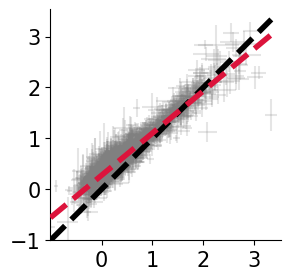

In [8]:
c=2.576

alpha = 0.2
gamma_color = 'gray'
dpi = 450

gamma_min, gamma_max = np.min((log_sc_gamma[gf], log_sn_gamma[gf])), np.max((log_sc_gamma[gf], log_sn_gamma[gf]))
num_diag = 100; gamma_diag = np.linspace(gamma_min, gamma_max, num_diag)
gamma_fit = m_*gamma_diag + b_

print(scipy.stats.ttest_ind(log_sc_gamma[gf],log_sn_gamma[gf]))

# --------------------

fig, ax = plt.subplots(figsize=(3,3))

ax.errorbar(log_sc_gamma[gf], log_sn_gamma[gf], c*sig_sc_gamma[gf], c*sig_sn_gamma[gf], linestyle='None', alpha=alpha, color=gamma_color)
ax.plot(gamma_diag, gamma_diag, linestyle='--', linewidth=4, color='black',zorder=3)
ax.plot(gamma_diag, gamma_fit, linestyle='--', linewidth=4, color='crimson',zorder=3)

eps = 0.2
ax.set_xticks([0, 1, 2, 3])
ax.set_xlim(gamma_min, gamma_max + eps); ax.set_ylim(gamma_min, gamma_max + eps)
ax.spines[['right', 'top']].set_visible(False)
ax.set_aspect('equal')
ax.tick_params(axis='both', labelsize=15)

formats = ['.png', '.svg', '.pdf']
for f in formats:
    plt.savefig(savedir+'sn_vs_sc_efflux'+f, bbox_inches='tight', transparent=True, dpi=dpi)
plt.show()

## 2. Uncertainty for sc vs sn

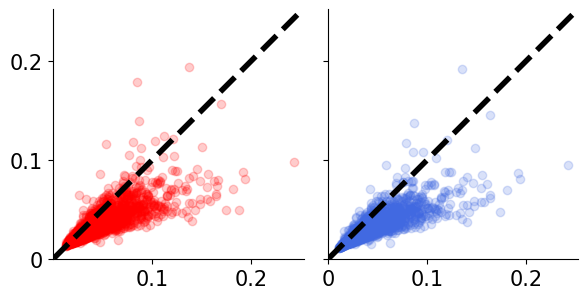

In [153]:
ncols = 2
alpha = 0.2
b_color = 'red'
beta_color = 'royalblue'
dpi = 450

sig_b_min, sig_beta_min = np.min((sig_sc_b[gf], sig_sn_b[gf])), np.min((sig_sc_beta[gf], sig_sn_beta[gf]))
sig_b_max, sig_beta_max = np.max((sig_sc_b[gf], sig_sn_b[gf])), np.max((sig_sc_beta[gf], sig_sn_beta[gf]))

num_diag = 100
sig_b_diag = np.linspace(sig_b_min, sig_b_max, num_diag); sig_beta_diag = np.linspace(sig_beta_min, sig_beta_max, num_diag)

# --------------------

fig, ax = plt.subplots(ncols = ncols, figsize=(6., 3), sharey=True)

ax[0].scatter(sig_sc_b[gf], sig_sn_b[gf], alpha=alpha, color=b_color)
ax[1].scatter(sig_sc_beta[gf], sig_sn_beta[gf], alpha=alpha, color=beta_color)

ax[0].plot(b_diag, b_diag, linestyle='--', linewidth=4, color='black',zorder=3)
ax[1].plot(beta_diag, beta_diag, linestyle='--', linewidth=4, color='black',zorder=3)

eps = 0.01
ax[0].set_xlim(0, sig_b_max + eps); ax[0].set_ylim(0, sig_b_max + eps)
ax[1].set_xlim(0, sig_beta_max + eps); ax[1].set_ylim(0, sig_beta_max + eps)

ax[0].set_yticks([0, 0.1, 0.2], ['0', 0.1, 0.2])
ax[0].set_xticks([0.1, 0.2])
ax[1].set_xticks([0, 0.1, 0.2], ['0', 0.1, 0.2])
for i in range(ncols):
    ax[i].spines[['right', 'top']].set_visible(False)
    ax[i].set_aspect('equal')
    ax[i].tick_params(axis='both', labelsize=15)
fig.tight_layout()

formats = ['.png', '.svg', '.pdf']
for f in formats:
    plt.savefig(savedir+'sn_vs_sc_uncertainty'+f, bbox_inches='tight', transparent=True, dpi=dpi)
plt.show()

In [63]:
num_fit_genes = len(sig_sn_b[gf])
print(num_fit_genes, ' well-fit genes\n')

print("For what percentage of well-fit genes does sn have a tighter burst size estimate?")
num_sn_wins = len(np.where( sig_sc_b[gf] - sig_sn_b[gf] > 0 )[0])

print(num_sn_wins); print(100*(num_sn_wins/num_fit_genes))
print()

print("For what percentage of well-fit genes does sn have a tighter splicing rate estimate?")
num_sn_wins = len(np.where( sig_sc_beta[gf] - sig_sn_beta[gf] > 0 )[0])

print(num_sn_wins); print(100*(num_sn_wins/num_fit_genes))

1896  well-fit genes

For what percentage of well-fit genes does sn have a tighter burst size estimate?
1610
84.915611814346

For what percentage of well-fit genes does sn have a tighter splicing rate estimate?
1720
90.71729957805907


## 3. Post-integration uncertainty vs min uncertainty

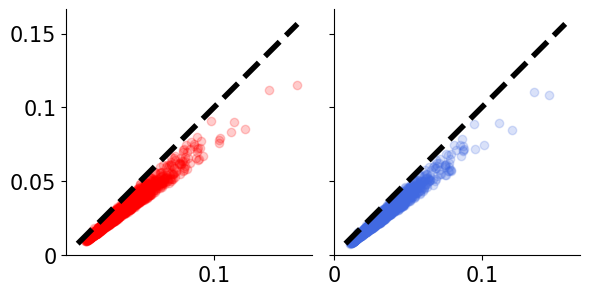

In [154]:
ncols = 2
alpha = 0.2
b_color = 'red'
beta_color = 'royalblue'
dpi = 450

x_min = np.min((sig_min_b[gf], sig_int_b[gf], sig_min_beta[gf], sig_int_beta[gf]))
x_max = np.max((sig_min_b[gf], sig_int_b[gf], sig_min_beta[gf], sig_int_beta[gf]))

num_diag = 100
x_diag = np.linspace(x_min, x_max, num_diag)

# --------------------

fig, ax = plt.subplots(ncols = ncols, figsize=(6., 3), sharey=True)

ax[0].scatter(sig_min_b[gf], sig_int_b[gf], alpha=alpha, color=b_color)
ax[1].scatter(sig_min_beta[gf], sig_int_beta[gf], alpha=alpha, color=beta_color)

ax[0].plot(x_diag, x_diag, linestyle='--', linewidth=4, color='black',zorder=3)
ax[1].plot(x_diag, x_diag, linestyle='--', linewidth=4, color='black',zorder=3)

eps = 0.01
ax[0].set_xlim(0, x_max + eps); ax[0].set_ylim(0, x_max + eps)
ax[1].set_xlim(0, x_max + eps); ax[1].set_ylim(0, x_max + eps)

ax[0].set_yticks([0, 0.05, 0.1, 0.15], ['0', 0.05, 0.1, 0.15])
ax[0].set_xticks([0.1])
ax[1].set_xticks([0, 0.1], ['0', 0.1])
for i in range(ncols):
    ax[i].spines[['right', 'top']].set_visible(False)
    ax[i].set_aspect('equal')
    ax[i].tick_params(axis='both', labelsize=15)
fig.tight_layout()

formats = ['.png', '.svg', '.pdf']
for f in formats:
    plt.savefig(savedir+'post_int_uncertainty'+f, bbox_inches='tight', transparent=True, dpi=dpi)
plt.show()

## 4. Post-integration distribution of uncertainty

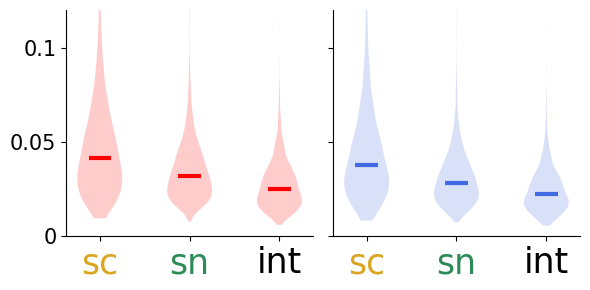

In [31]:
ncols = 2
alpha = 0.2
b_color = 'red'
beta_color = 'royalblue'
dpi = 450

# --------------------

fig, ax = plt.subplots(ncols = ncols, figsize=(6., 3), sharey=True, sharex=True)

parts_b = ax[0].violinplot([sig_sc_b, sig_sn_b, sig_int_b], showmedians=True, showextrema=False)
parts_beta = ax[1].violinplot([sig_sc_beta, sig_sn_beta, sig_int_beta], showmedians=True, showextrema=False)

vp_b = parts_b['cmedians']; vp_b.set_edgecolor(b_color); vp_b.set_linewidth(3)
vp_beta = parts_beta['cmedians']; vp_beta.set_edgecolor(beta_color); vp_beta.set_linewidth(3)

for pc in parts_b['bodies']:
    pc.set_facecolor(b_color); pc.set_alpha(alpha)
    
for pc in parts_beta['bodies']:
    pc.set_facecolor(beta_color); pc.set_alpha(alpha)

ax[0].set_xticks([1, 2, 3], ['sc', 'sn', 'int'])
[t.set_color(i) for (i,t) in zip(['goldenrod', 'seagreen', 'black'],ax[0].xaxis.get_ticklabels())]
[t.set_color(i) for (i,t) in zip(['goldenrod', 'seagreen', 'black'],ax[1].xaxis.get_ticklabels())]


ax[1].set_yticks([0, 0.05, 0.1], ['0', '0.05', '0.1'])  
ax[0].set_ylim(0, 0.12)
for i in range(ncols):
    ax[i].spines[['right', 'top']].set_visible(False)
    ax[i].tick_params(axis='both', labelsize=15)
    ax[i].tick_params(axis='x', labelsize=25)
fig.tight_layout()

formats = ['.png', '.svg', '.pdf']
for f in formats:
    plt.savefig(savedir+'uncertainty_dist'+f, bbox_inches='tight', transparent=True, dpi=dpi)
plt.show()

------------------